# Project: [Soccer Database](https://docs.google.com/document/d/e/2PACX-1vTlVmknRRnfy_4eTrjw5hYGaiQim5ctr9naaRd4V9du2B5bxpd8FEH3KtDgp8qVekw7Cj1GLk1IXdZi/pub)

## Table of Contents
<ul>
    <li><a href="#intro">Introduction</a></li>
    <li><a href="#wrangling">Data Wrangling</a></li>
    <li><a href="#eda">Exploratory Data Analysis</a></li>
    <li><a href="#conclusions">Conclusions</a></li>
</ul>

<h2 id="intro">Introduction</h2>

---
*The soccer database comes from [Kaggle](https://www.kaggle.com/hugomathien/soccer) and is well suited for data analysis<br>
It contains data for soccer matches, players, and teams from several European countries from 2008 to 2016.*

### The Dataset Includes:
1. +25,000 matches
2. +10,000 players
3. 11 European Countries with their lead championship
4. Seasons 2008 to 2016
5. Players and Teams' attributes* sourced from EA Sports' FIFA video game series, including the weekly updates
6. Match events (Season, League, Home Team goals, Away Team goals) for +10,000 matches
<br>
<br>

***The database is stored in a SQLite database.***
> Using [DB Browser](http://sqlitebrowser.org/) I'll access the database files, explore them, and check for valid PKs, FKs, and the suitable features for my research via SQL QUERIES first by checking for duplicates and Nulls, then finally gathering the required data via SQL JOINS and storing them in dataframes.

### Research Questions
---
* ***What teams experienced a significant improvement or fell over the period?***
* ***What team attributes lead to the most victories?***
* ***Which players had the most penalties?***

In [1]:
# import modules
from datetime import datetime

import numpy as np
import pandas as pd

from matplotlib.cbook import boxplot_stats

import sqlite3

import re

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
sns.set_palette('Set2')

# Avoid the warning: [SettingWithCopyWarning : A value is trying to be set on a copy of a slice from a DataFrame]
pd.options.mode.chained_assignment = None

In [2]:
# list the directory contents
!ls

Investigate_a_Dataset.ipynb  soccer_db.sqlite


In [3]:
# Connect to Database
conn = sqlite3.connect('file:soccer_db.sqlite?mode=ro', uri=True)

<h2 id="wrangling">Data Wrangling</h2>
<br>

### General Properties

By taking a quick look at the database on the Kaggle website, we note that the database includes seven data tables.

We need to collect several columns from each, and therefore we've to select suitable keys to be the basis of joins.

We'll use the Software DB Browser to access the database files and explore them. Then using SQL Queries, we'll check for valid, suitable keys to hold the joins on it, and in selecting then gather the required columns that we need from each table.

<mark>We'll use the <b>queries</b> below to determine the proper keys and features per each table.</mark>
>##### To check for Null:
>```
SELECT <Column_name>
FROM <Table_name>
WHERE <Column_name> IS NULL;
>```

>##### To check for Duplicates:
>```
SELECT <Column_name>, COUNT(*)
FROM <Table_name>
GROUP BY <Column_name>
HAVING COUNT(*)>1
>```

### Check for Valid, Suitable Keys

Checking the validity of keys per each table included in the database to hold our JOINS on, by implementing the previously mentioned SQL Queries in the software DB Browser, we've found that the suitable keys are:
#### Country Table
>* ***id*** : ***PK***

#### League Table
>* ***id*** : ***PK***
>* ***country_id*** : ***PK, FK***

#### Match Table
>* ***match_api_id*** : ***PK***
>* ***country_id*** : ***FK***
>* ***league_id*** : ***FK***
>* ***home_team_api_id*** : ***FK***
>* ***away_team_api_id*** : ***FK***

#### Team Table
>* ***team_api_id*** : ***PK***

#### Team_Attributes Table
>* ***team_api_id*** : ***FK***

#### Player
>* ***player_api_id*** : ***PK***

#### Player_Attributes
>* ***player_api_id*** : ***FK***

<br><br>

### Regarding our Research Questions, we've to collect three DataTables using SQL JOINS:<br>

* The **1st DataTable** includes the features:
>* Country Name
>* League
>* Team Name
>* Season
>* Goals For
>* Goals Against

* The **2nd DataTable** includes the features:<br><br>
<mark><b><i>"By looking at the numerical features that contain the assessed teams' Attribute values on Kaggle, we should notice that most of them are not valid due to the nulls. Therefore, we will choose the ones with categorical values"</i></b></mark>
>* Team name
>* Assessing date
>* Build Up Play Speed (Class)
>* Build Up Play Dribbling (Class)
>* Build Up Play Passing (Class)
>* Build Up Play Positioning (Class)
>* Chance Creation Passing (Class)
>* Chance Creation Crossing (Class)
>* Chance Creation Shooting (Class)
>* Chance Creation Positioning (Class)
>* Defence Pressure (Class)
>* Defence Aggression (Class)
>* Defence Team Width (Class)
>* Defence Defender Line (Class)

* The **3rd DataTable** includes the features:
>* Player Name
>* Date
>* Penalty Score

<br>
<br>

*I've created an ERD that includes the previously mentioned keys and features required for our research questions using [lucid App](https://lucid.app)*
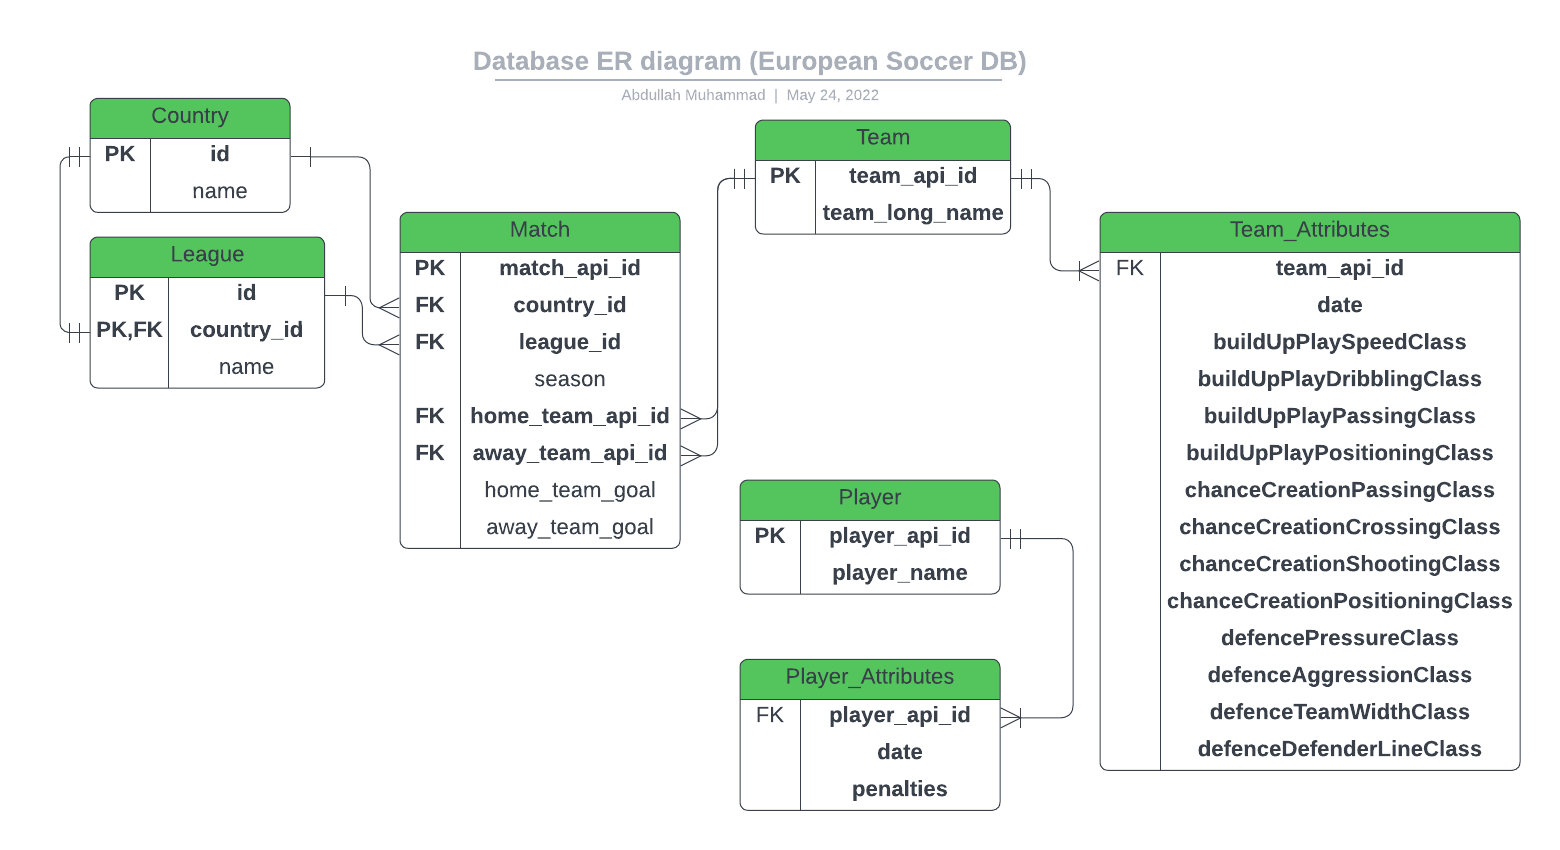


### The 1st DataTable
<br>

In [4]:
#------------------------------------------------------------------------------------------------------
# Gather the features from the database, store it in a dataframe and finally merge it into a single dataframe
#------------------------------------------------------------------------------------------------------
# Gather Match datatable that includes only Matches results for "Home Team"
hometeam_data_query = """SELECT C.name AS 'country',
                                L.name AS 'league', 
                                HT.team_long_name AS 'team', 
                                M.season AS 'season', 
                                M.home_team_goal AS 'goals_for', 
                                M.away_team_goal AS 'goals_against' 
                         FROM Country AS C, League AS L, Match AS M, Team AS HT 
                         ON C.id = L.country_id 
                         AND L.id = M.league_id 
                         AND HT.team_api_id = M.home_team_api_id 
                         ORDER BY country, league, team, season;"""
hometeam_df = pd.read_sql(hometeam_data_query, conn)

# Gather Match datatable that includes only Matches results for "Away Team"
awayteam_data_query = """SELECT C.name AS 'country', 
                                L.name AS 'league', 
                                HT.team_long_name AS 'team', 
                                M.season AS 'season', 
                                M.away_team_goal AS 'goals_for', 
                                M.home_team_goal AS 'goals_against' 
                         FROM Country AS C, League AS L, Match AS M, Team AS HT 
                         ON C.id = L.country_id 
                         AND L.id = M.league_id 
                         AND HT.team_api_id = M.away_team_api_id 
                         ORDER BY country, league, team, season;"""
awayteam_df = pd.read_sql(awayteam_data_query, conn)

# Merge the Two dataframes into a single dataframe
# So we have a table of all matches results of all teams for both cases, Home and Away.
match_df = pd.concat([hometeam_df, awayteam_df], ignore_index=True)

In [5]:
# Check the returned Dataframe:
match_df.info()
match_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51958 entries, 0 to 51957
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   country        51958 non-null  object
 1   league         51958 non-null  object
 2   team           51958 non-null  object
 3   season         51958 non-null  object
 4   goals_for      51958 non-null  int64 
 5   goals_against  51958 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 2.4+ MB


,country,league,team,season,goals_for,goals_against
0,Belgium,Belgium Jupiler League,Beerschot AC,2008/2009,1,3
1,Belgium,Belgium Jupiler League,Beerschot AC,2008/2009,1,3
2,Belgium,Belgium Jupiler League,Beerschot AC,2008/2009,0,2
3,Belgium,Belgium Jupiler League,Beerschot AC,2008/2009,3,0
4,Belgium,Belgium Jupiler League,Beerschot AC,2008/2009,2,0


In [6]:
#------------------------------------------------------------------------------------------------------
# Create the new features: [Matches, won, draw, lost, goals for, goals against, goal difference]
#------------------------------------------------------------------------------------------------------

# A column that counts each game played by a team as a single match.
# So when aggregating all teams by sum, we get the number of games played by each team.
match_df['played'] = np.repeat(1, len(match_df), axis=0)

# Compare the results of each match, which are 'Goals for' and 'Goals against'
# Once for winning, once for drawing, and the last one for lost
# then multiply each returned column by 1 to translate bool value into integer value 1
# So when we aggregate by sum, we get the number of won, drawn, and lost
match_df['won'] = (match_df['goals_for'].gt(match_df['goals_against'])).mul(1)
match_df['drawn'] = (match_df['goals_for'].eq(match_df['goals_against'])).mul(1)
match_df['lost'] = (match_df['goals_for'].lt(match_df['goals_against'])).mul(1)

# Calculate the points:
# 'Won' get 3 points, 'drawn' get 1 point, and 'lost' get nothing, 
# therefore multiply the 'won' column by 3, then add to it the 'drawn' column to get the total points
match_df['points'] = (match_df['won'].mul(3)).add(match_df['drawn'])

# Calculate the goal difference "goals for - goals against" to compare teams by both points and goal difference.
match_df['goal_difference'] = match_df['goals_for'].subtract(match_df['goals_against'])





# Re-arrange the Dataframe Columns
match_df = match_df.reindex(columns=['country', 
                                     'league', 
                                     'team', 
                                     'season', 
                                     'played', 
                                     'won', 
                                     'drawn', 
                                     'lost', 
                                     'goals_for', 
                                     'goals_against', 
                                     'goal_difference', 
                                     'points'])

# Aggregate the new features by SUM, then reset the index.
match_df = match_df.groupby(['country', 'league', 'team', 'season']).sum().reset_index()

In [7]:
# Check the returned Dataframe:
match_df.info()
match_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1478 entries, 0 to 1477
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   country          1478 non-null   object
 1   league           1478 non-null   object
 2   team             1478 non-null   object
 3   season           1478 non-null   object
 4   played           1478 non-null   int64 
 5   won              1478 non-null   int64 
 6   drawn            1478 non-null   int64 
 7   lost             1478 non-null   int64 
 8   goals_for        1478 non-null   int64 
 9   goals_against    1478 non-null   int64 
 10  goal_difference  1478 non-null   int64 
 11  points           1478 non-null   int64 
dtypes: int64(8), object(4)
memory usage: 138.7+ KB


,country,league,team,season,played,won,drawn,lost,goals_for,goals_against,goal_difference,points
0,Belgium,Belgium Jupiler League,Beerschot AC,2008/2009,34,11,9,14,44,42,2,42
1,Belgium,Belgium Jupiler League,Beerschot AC,2009/2010,28,9,8,11,30,43,-13,35
2,Belgium,Belgium Jupiler League,Beerschot AC,2010/2011,30,5,11,14,24,40,-16,26
3,Belgium,Belgium Jupiler League,Beerschot AC,2011/2012,30,9,9,12,45,51,-6,36
4,Belgium,Belgium Jupiler League,Beerschot AC,2012/2013,30,6,5,19,31,61,-30,23


In [8]:
# Check the # of unique values:
match_df.loc[:, 'country':'season'].nunique()

country     11
league      11
team       296
season       8
dtype: int64

In [9]:
# Check the unique values per country:
match_df.country.unique()

array(['Belgium', 'England', 'France', 'Germany', 'Italy', 'Netherlands',
       'Poland', 'Portugal', 'Scotland', 'Spain', 'Switzerland'],
      dtype=object)

In [10]:
# Check the unique values per league:
match_df.league.unique()

array(['Belgium Jupiler League', 'England Premier League',
       'France Ligue 1', 'Germany 1. Bundesliga', 'Italy Serie A',
       'Netherlands Eredivisie', 'Poland Ekstraklasa',
       'Portugal Liga ZON Sagres', 'Scotland Premier League',
       'Spain LIGA BBVA', 'Switzerland Super League'], dtype=object)

In [11]:
# Check the unique values per team:
match_df.team.unique()

array(['Beerschot AC', 'Club Brugge KV', 'FCV Dender EH', 'KAA Gent',
       'KAS Eupen', 'KRC Genk', 'KSV Cercle Brugge', 'KSV Roeselare',
       'KV Kortrijk', 'KV Mechelen', 'KV Oostende', 'KVC Westerlo',
       'Lierse SK', 'Oud-Heverlee Leuven', 'RAEC Mons', 'RSC Anderlecht',
       'Royal Excel Mouscron', 'SV Zulte-Waregem', 'Sint-Truidense VV',
       'Sporting Charleroi', 'Sporting Lokeren', 'Standard de Liège',
       'Tubize', 'Waasland-Beveren', 'Arsenal', 'Aston Villa',
       'Birmingham City', 'Blackburn Rovers', 'Blackpool',
       'Bolton Wanderers', 'Bournemouth', 'Burnley', 'Cardiff City',
       'Chelsea', 'Crystal Palace', 'Everton', 'Fulham', 'Hull City',
       'Leicester City', 'Liverpool', 'Manchester City',
       'Manchester United', 'Middlesbrough', 'Newcastle United',
       'Norwich City', 'Portsmouth', 'Queens Park Rangers', 'Reading',
       'Southampton', 'Stoke City', 'Sunderland', 'Swansea City',
       'Tottenham Hotspur', 'Watford', 'West Bromwich Al

In [12]:
# Check the unique values per season:
match_df.season.unique()

array(['2008/2009', '2009/2010', '2010/2011', '2011/2012', '2012/2013',
       '2014/2015', '2015/2016', '2013/2014'], dtype=object)

<br>
<br>

### The 2nd DataTable
<br>

In [13]:
#------------------------------------------------------------------------------------------------------
# Access the database and use SQL JOINS to gather the required Datatable.
#------------------------------------------------------------------------------------------------------
team_attributes_data_query = """SELECT T.team_long_name AS team, 
                                       TA.date AS season, 
                                       TA.buildUpPlaySpeedClass, 
                                       TA.buildUpPlayDribblingClass, 
                                       TA.buildUpPlayPassingClass, 
                                       TA.buildUpPlayPositioningClass, 
                                       TA.chanceCreationPassingClass, 
                                       TA.chanceCreationCrossingClass, 
                                       TA.chanceCreationShootingClass, 
                                       TA.chanceCreationPositioningClass, 
                                       TA.defencePressureClass, 
                                       TA.defenceAggressionClass, 
                                       TA.defenceTeamWidthClass, 
                                       TA.defenceDefenderLineClass 
                                FROM Team_Attributes AS TA, Team AS T 
                                ON T.team_api_id = TA.team_api_id;"""
team_attr_df = pd.read_sql(team_attributes_data_query, conn) # Store in dataframe

In [14]:
# Check the returned Dataframe:
team_attr_df.info()
team_attr_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   team                            1458 non-null   object
 1   season                          1458 non-null   object
 2   buildUpPlaySpeedClass           1458 non-null   object
 3   buildUpPlayDribblingClass       1458 non-null   object
 4   buildUpPlayPassingClass         1458 non-null   object
 5   buildUpPlayPositioningClass     1458 non-null   object
 6   chanceCreationPassingClass      1458 non-null   object
 7   chanceCreationCrossingClass     1458 non-null   object
 8   chanceCreationShootingClass     1458 non-null   object
 9   chanceCreationPositioningClass  1458 non-null   object
 10  defencePressureClass            1458 non-null   object
 11  defenceAggressionClass          1458 non-null   object
 12  defenceTeamWidthClass           1458 non-null   

,team,season,buildUpPlaySpeedClass,buildUpPlayDribblingClass,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassingClass,chanceCreationCrossingClass,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressureClass,defenceAggressionClass,defenceTeamWidthClass,defenceDefenderLineClass
0,FC Aarau,2010-02-22 00:00:00,Balanced,Little,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
1,FC Aarau,2014-09-19 00:00:00,Balanced,Normal,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
2,FC Aarau,2015-09-10 00:00:00,Balanced,Normal,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
3,Aberdeen,2010-02-22 00:00:00,Fast,Little,Long,Organised,Risky,Lots,Lots,Organised,Medium,Double,Wide,Cover
4,Aberdeen,2011-02-22 00:00:00,Balanced,Little,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover


In [15]:
#------------------------------------------------------------------------------------------------------
# Translate the assessing dates in the season column into their corresponding play season:
#------------------------------------------------------------------------------------------------------

# Convert the dates from strings to DateTime, which include only Month and Year.
team_attr_df['season'] = pd.to_datetime(team_attr_df['season']).dt.to_period('M')

# Change back the values of the same column into strings again.
team_attr_df['season'] = team_attr_df['season'].dt.strftime("%Y-%m")





# Find the unique date values and replace each of them with its corresponding season value.
team_attr_df['season'].unique()

to_replace_ls = ['2010-02', '2014-09', '2015-09', '2011-02', '2012-02', '2013-09']
values_ls = ['2009/2010', '2014/2015', '2015/2016', '2010/2011', '2011/2012', '2013/2014']

team_attr_df['season'].replace(to_replace= to_replace_ls, value= values_ls, inplace=True)

In [16]:
# Check the returned Dataframe:
team_attr_df.info()
team_attr_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   team                            1458 non-null   object
 1   season                          1458 non-null   object
 2   buildUpPlaySpeedClass           1458 non-null   object
 3   buildUpPlayDribblingClass       1458 non-null   object
 4   buildUpPlayPassingClass         1458 non-null   object
 5   buildUpPlayPositioningClass     1458 non-null   object
 6   chanceCreationPassingClass      1458 non-null   object
 7   chanceCreationCrossingClass     1458 non-null   object
 8   chanceCreationShootingClass     1458 non-null   object
 9   chanceCreationPositioningClass  1458 non-null   object
 10  defencePressureClass            1458 non-null   object
 11  defenceAggressionClass          1458 non-null   object
 12  defenceTeamWidthClass           1458 non-null   

,team,season,buildUpPlaySpeedClass,buildUpPlayDribblingClass,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassingClass,chanceCreationCrossingClass,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressureClass,defenceAggressionClass,defenceTeamWidthClass,defenceDefenderLineClass
0,FC Aarau,2009/2010,Balanced,Little,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
1,FC Aarau,2014/2015,Balanced,Normal,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
2,FC Aarau,2015/2016,Balanced,Normal,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
3,Aberdeen,2009/2010,Fast,Little,Long,Organised,Risky,Lots,Lots,Organised,Medium,Double,Wide,Cover
4,Aberdeen,2010/2011,Balanced,Little,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover


In [17]:
# Check the # of unique values:
team_attr_df.nunique()

team                              285
season                              6
buildUpPlaySpeedClass               3
buildUpPlayDribblingClass           3
buildUpPlayPassingClass             3
buildUpPlayPositioningClass         2
chanceCreationPassingClass          3
chanceCreationCrossingClass         3
chanceCreationShootingClass         3
chanceCreationPositioningClass      2
defencePressureClass                3
defenceAggressionClass              3
defenceTeamWidthClass               3
defenceDefenderLineClass            2
dtype: int64

In [18]:
# Check the unique values per team:
team_attr_df.team.unique()

array(['FC Aarau', 'Aberdeen', 'AC Ajaccio', 'Milan',
       'Académica de Coimbra', 'ADO Den Haag', 'Ajax', 'UD Almería',
       'RSC Anderlecht', 'Angers SCO', 'Arka Gdynia', 'AC Arles-Avignon',
       'DSC Arminia Bielefeld', 'FC Arouca', 'Arsenal', 'Aston Villa',
       'Atalanta', 'Athletic Club de Bilbao', 'Atlético Madrid',
       'FC Augsburg', 'AJ Auxerre', 'AZ', 'FC Barcelona', 'Bari',
       'FC Basel', 'Bayer 04 Leverkusen', 'FC Bayern Munich',
       'Beerschot AC', 'SC Beira Mar', 'CF Os Belenenses',
       'AC Bellinzona', 'SL Benfica', 'Birmingham City',
       'Blackburn Rovers', 'Blackpool', 'Boavista FC', 'VfL Bochum',
       'Bologna', 'Bolton Wanderers', 'Girondins de Bordeaux',
       'Borussia Dortmund', 'Borussia Mönchengladbach',
       "US Boulogne Cote D'Opale", 'Bournemouth', 'SC Braga', 'Brescia',
       'Stade Brestois 29', 'Burnley', 'SM Caen', 'Cagliari',
       'SC Cambuur', 'Cardiff City', 'Carpi', 'Catania',
       'RC Celta de Vigo', 'Celtic', 'KSV C

In [19]:
# Check the unique values per season:
team_attr_df.season.unique()

array(['2009/2010', '2014/2015', '2015/2016', '2010/2011', '2011/2012',
       '2013/2014'], dtype=object)

In [20]:
# Check the unique values per each team attribute in team_attr_df:
[team_attr_df[team_attr_df.columns[2:]][i].unique() for i in team_attr_df.columns[2:]]

[array(['Balanced', 'Fast', 'Slow'], dtype=object),
 array(['Little', 'Normal', 'Lots'], dtype=object),
 array(['Mixed', 'Long', 'Short'], dtype=object),
 array(['Organised', 'Free Form'], dtype=object),
 array(['Normal', 'Risky', 'Safe'], dtype=object),
 array(['Normal', 'Lots', 'Little'], dtype=object),
 array(['Normal', 'Lots', 'Little'], dtype=object),
 array(['Organised', 'Free Form'], dtype=object),
 array(['Medium', 'Deep', 'High'], dtype=object),
 array(['Press', 'Double', 'Contain'], dtype=object),
 array(['Normal', 'Wide', 'Narrow'], dtype=object),
 array(['Cover', 'Offside Trap'], dtype=object)]

<br>
<br>

<mark><b>We should notice that the number of unique values of teams in the match_df is more than the number of unique values of teams in the team_attr_df</b></mark>

In [21]:
# Check for the unassessed teams:
attr_teams_set = set(team_attr_df.team.unique())
match_teams_set = set(match_df.team.unique())

attr_teams_set.symmetric_difference(match_teams_set)

{'Amadora',
 'FC Volendam',
 'FCV Dender EH',
 'Feirense',
 'Lugano',
 'Portimonense',
 'Termalica Bruk-Bet Nieciecza',
 'Tondela',
 'Trofense',
 'Tubize',
 'Uniao da Madeira'}

<br>
<br>

<mark><b>Also, the number of unique values of seasons in the match_df is more than the number of unique values of seasons in the team_attr_df</b></mark>

In [22]:
# Check the seasons during which the assessment didn't perform:
attr_seasons_set = set(team_attr_df.season.unique())
match_seasons_set = set(match_df.season.unique())

attr_seasons_set.symmetric_difference(match_seasons_set)

{'2008/2009', '2012/2013'}

<br>
<br>

### The 3rd DataTable
<br>

In [23]:
#------------------------------------------------------------------------------------------------------
# Access the database and use SQL JOINS to gather the required Datatable.
#------------------------------------------------------------------------------------------------------
penalties_data_query = """SELECT P.player_name, PA.date, PA.penalties 
                          FROM Player AS P, Player_Attributes AS PA 
                          ON P.player_api_id = PA.player_api_id 
                          ORDER BY penalties DESC;"""
penalties_df = pd.read_sql(penalties_data_query, conn) # Store in dataframe

In [24]:
# Check the returned Dataframe:
penalties_df.info()
penalties_df.head(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   player_name  183978 non-null  object 
 1   date         183978 non-null  object 
 2   penalties    183142 non-null  float64
dtypes: float64(1), object(2)
memory usage: 4.2+ MB


,player_name,date,penalties
0,Rickie Lambert,2016-03-10 00:00:00,96.0
1,Rickie Lambert,2015-12-24 00:00:00,96.0
2,Rickie Lambert,2015-10-23 00:00:00,96.0
3,Rickie Lambert,2015-09-21 00:00:00,96.0
4,Andrea Pirlo,2009-02-22 00:00:00,95.0
5,Andrea Pirlo,2008-08-30 00:00:00,95.0
6,Mario Balotelli,2014-01-24 00:00:00,95.0
7,Mario Balotelli,2013-12-20 00:00:00,95.0
8,Mario Balotelli,2013-11-01 00:00:00,95.0
9,Mario Balotelli,2013-10-18 00:00:00,95.0


In [25]:
# Check for nulls in penalties column:
penalties_df.penalties.isnull().sum()

836

In [26]:
# Check the # of unique values:
penalties_df.nunique()

player_name    10848
date             197
penalties         94
dtype: int64

In [27]:
# Remove Nulls
penalties_df.dropna(inplace=True)

# Convert the penalties column dtype into integer dtype
penalties_df['penalties'] = pd.to_numeric(penalties_df['penalties'], downcast='integer')

# Convert the date column dtype into datetime without the hours
penalties_df['date'] = pd.to_datetime(penalties_df['date']).dt.date

In [28]:
# Check the returned Dataframe:
penalties_df.info()
penalties_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183142 entries, 0 to 183141
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   player_name  183142 non-null  object
 1   date         183142 non-null  object
 2   penalties    183142 non-null  int8  
dtypes: int8(1), object(2)
memory usage: 4.4+ MB


,player_name,date,penalties
0,Rickie Lambert,2016-03-10,96
1,Rickie Lambert,2015-12-24,96
2,Rickie Lambert,2015-10-23,96
3,Rickie Lambert,2015-09-21,96
4,Andrea Pirlo,2009-02-22,95


<br><br>
**Find the highest score of penalties recorded per each player**

In [29]:
# Find Max penalties record per player
max_penalties_df = penalties_df.groupby(['player_name'], as_index=False)['penalties'].max()

# Find the last recording date for each player's maximum penalty score.
max_penalties_df = max_penalties_df.merge(penalties_df, how='left', on=['player_name', 'penalties']
                                         ).groupby(['player_name', 'penalties'], as_index=False)['date'].max()

# Sort the Dataframe in descending order by penalty score
max_penalties_df.sort_values('penalties', ascending=False, ignore_index=True, inplace=True)

In [30]:
# Check the returned Dataframe:
max_penalties_df.info()
max_penalties_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10848 entries, 0 to 10847
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   player_name  10848 non-null  object
 1   penalties    10848 non-null  int8  
 2   date         10848 non-null  object
dtypes: int8(1), object(2)
memory usage: 180.2+ KB


,player_name,penalties,date
0,Rickie Lambert,96,2016-03-10
1,Andrea Pirlo,95,2009-02-22
2,Xavi Hernandez,95,2010-02-22
3,Mario Balotelli,95,2014-01-24
4,Paul Scholes,95,2010-02-22
...,...,...,...
10843,Igor Stefanovic,11,2016-01-14
10844,Giedrius Arlauskis,11,2016-02-04
10845,Jakub Szumski,11,2016-03-10
10846,Timothy van der Meulen,10,2011-02-22


In [31]:
# Penalties data summary statistics
max_penalties_df.describe()[1:]

,penalties
mean,60.392054
std,14.657931
min,9.000000
25%,51.000000
50%,62.000000
75%,71.000000
max,96.000000


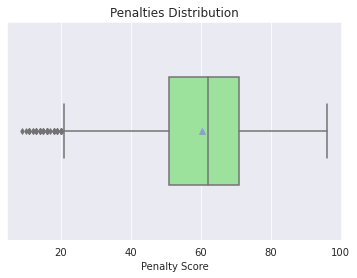

In [32]:
# Penalties frequency distribution using BoxPlot
sns.boxplot(x='penalties', data=max_penalties_df, color='lightgreen', fliersize=4,width=(0.5), showmeans=True)
plt.xlabel('Penalty Score')
plt.title('Penalties Distribution');

<mark><b><i>"We can see that some values are acting as outliers"</i></b></mark>

In [33]:
# Return a dictionary of statistics used to draw the box and whisker plot
boxplot_stats_dict = plt.cbook.boxplot_stats(max_penalties_df['penalties'])[0]

boxplot_stats_dict

{'mean': 60.39205383480826,
 'iqr': 20.0,
 'cilo': 61.69852256623779,
 'cihi': 62.30147743376221,
 'whishi': 96,
 'whislo': 21,
 'fliers': array([20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 18, 18, 17, 16,
        16, 16, 16, 16, 16, 16, 15, 15, 15, 14, 14, 14, 14, 13, 13, 13, 13,
        12, 12, 11, 11, 11, 11, 10,  9], dtype=int8),
 'q1': 51.0,
 'med': 62.0,
 'q3': 71.0}

In [34]:
# Return a list of the outliers' unique values!
outliers_list = list(set(boxplot_stats_dict.get('fliers')))
outliers_list

[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

<br><br>**Remove the Outliers**

In [35]:
# Return a Dataframe that only contains the values that aren't inside the given list of the outliers' values!
max_penalties_df = max_penalties_df[max_penalties_df['penalties'].isin(outliers_list) == False]

<br><br>**<mark>Check the returned dataframe cleanliness</mark>**

In [36]:
# Summary statistics
max_penalties_df.describe()[1:]

,penalties
mean,60.565982
std,14.416520
min,21.000000
25%,51.000000
50%,62.000000
75%,71.000000
max,96.000000


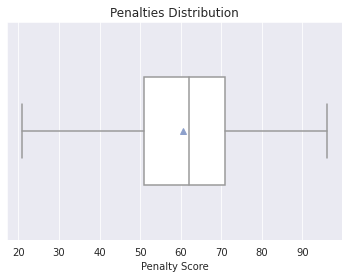

In [37]:
# Frequency distribution using BoxPlot
sns.boxplot(x='penalties', data=max_penalties_df, color='white', fliersize=4,width=(0.5), showmeans=True)
plt.xlabel('Penalty Score')
plt.title('Penalties Distribution');

In [38]:
# Check the returned Dataframe
max_penalties_df.info()
max_penalties_df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10806 entries, 0 to 10805
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   player_name  10806 non-null  object
 1   penalties    10806 non-null  int8  
 2   date         10806 non-null  object
dtypes: int8(1), object(2)
memory usage: 263.8+ KB


,player_name,penalties,date
0,Rickie Lambert,96,2016-03-10
1,Andrea Pirlo,95,2009-02-22
2,Xavi Hernandez,95,2010-02-22
3,Mario Balotelli,95,2014-01-24
4,Paul Scholes,95,2010-02-22
...,...,...,...
10801,Stole Dimitrievski,21,2015-11-12
10802,Nico Pellatz,21,2014-01-24
10803,Jasper Cillessen,21,2016-04-28
10804,Patrick De Vlamynck,21,2015-05-29


<br><mark><b><i>We should notice that in the player_name's column, there're values that mix names with the player's number, as is the case with the player at index No. 10805</i></b></mark>

In [39]:
# Split the player_name values by the delimiter',' once it exists,
# and count the extracted values after the delimiter.
max_penalties_df['player_name'].str.split(',', n=1, expand=True)[1].count()

79

In [40]:
# Clean the player_name column
max_penalties_df['player_name'] = max_penalties_df['player_name'].str.split(',', n=1, expand=True)[0]

# Check the returned column
max_penalties_df['player_name'].str.split(',', n=1, expand=True)

,0
0,Rickie Lambert
1,Andrea Pirlo
2,Xavi Hernandez
3,Mario Balotelli
4,Paul Scholes
...,...
10801,Stole Dimitrievski
10802,Nico Pellatz
10803,Jasper Cillessen
10804,Patrick De Vlamynck


<h2 id="eda">Exploratory Data Analysis</h2>

<br><br>

### Research Question 1 : What teams experienced a significant improvement or fell over the period?

<br>**Find the teams with the highest points difference over seasons**

In [41]:
# Aggregate points by the function numpy.ptp() to calculate the points range for each team over seasons.
# Where Points Range = Max points - Min points
pts_range_df = match_df.groupby(['country', 'league', 'team']
                               ).agg({'points': np.ptp}).reset_index().rename(columns = {'points':'points_diff'})

# Aggregate by maximum to find the maximum range per league.
max_range_df = pts_range_df.groupby(['country', 'league']).max(numeric_only=True).reset_index()

# Merge pts_range_df with max_range_df to return a dataframe 
# that includes only teams with max points range per league.
teams_max_range_df = pd.merge(max_range_df, pts_range_df, on=['country', 'league', 'points_diff']
                             ).reindex(columns = ['country', 'league', 'team', 'points_diff'])

# Merge teams_max_range_df with match_df to return a dataframe 
# that includes the teams with the maximum range, including its Minimum and Maximum Points.
teams_min_max_df = teams_max_range_df[['country', 'league', 'team']
                                     ].merge(match_df, how='inner', on=['country', 'league', 'team']
                                            ).groupby(['country', 'league', 'team'])['points'].agg(['min','max']
                                                                                                  ).reset_index()

# Merge teams_min_max_df with match_df once on minimum without maximum, and once on maximum without minimum.
teams_min_df = teams_min_max_df.merge(match_df, 
                                      how='inner', 
                                      left_on=['country', 'league', 'team', 'min'], 
                                      right_on=['country', 'league', 'team', 'points'])

teams_max_df = teams_min_max_df.merge(match_df, 
                                      how='inner', 
                                      left_on=['country', 'league', 'team', 'max'], 
                                      right_on=['country', 'league', 'team', 'points'])



# Finally combine the two returned dataframes to create a dataframe with all teams' data with the highest points range.
teams_highest_df = pd.concat([teams_min_df, teams_max_df], ignore_index=True
                            ).groupby(['country', 'league', 'team', 'season']
                                     ).sum().reset_index().reindex(columns=match_df.columns)

In [42]:
# Check the returned Dataframe:
teams_highest_df.info()
teams_highest_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   country          22 non-null     object
 1   league           22 non-null     object
 2   team             22 non-null     object
 3   season           22 non-null     object
 4   played           22 non-null     int64 
 5   won              22 non-null     int64 
 6   drawn            22 non-null     int64 
 7   lost             22 non-null     int64 
 8   goals_for        22 non-null     int64 
 9   goals_against    22 non-null     int64 
 10  goal_difference  22 non-null     int64 
 11  points           22 non-null     int64 
dtypes: int64(8), object(4)
memory usage: 2.2+ KB


,country,league,team,season,played,won,drawn,lost,goals_for,goals_against,goal_difference,points
0,Belgium,Belgium Jupiler League,KAA Gent,2013/2014,6,3,1,2,11,6,5,10
1,Belgium,Belgium Jupiler League,KAA Gent,2015/2016,30,17,9,4,56,29,27,60
2,England,England Premier League,Aston Villa,2009/2010,38,17,13,8,52,39,13,64
3,England,England Premier League,Aston Villa,2015/2016,38,3,8,27,27,76,-49,17
4,France,France Ligue 1,Paris Saint-Germain,2009/2010,38,12,11,15,50,46,4,47


<br><br><br>
**Create a DataFrame of proportions to represent the teams' performance over different seasons, which includes the features**:<br>
>* ***Won Proportion***:
The proportion of won from the total played games.
>* ***Drawn Proportion***:
The proportion of drawn from the total played games.
>* ***Lost Proportion***:
The proportion of lost from the total played games.
>* ***Points Proportion***:
The proportion of points to <mark>the total possible points if the team won all the games played.</mark>

In [43]:
#------------------------------------------------------------------------------------------------------
# Translate values in the columns: [won, drawn, lost, points] into proportions.
#------------------------------------------------------------------------------------------------------
teams_prop_df = teams_highest_df[['country', 'league', 'team', 'season', 'played']]
teams_prop_df['won_prop'] = teams_highest_df['won'].div(teams_highest_df['played'])
teams_prop_df['drawn_prop'] = teams_highest_df['drawn'].div(teams_highest_df['played'])
teams_prop_df['lost_prop'] = teams_highest_df['lost'].div(teams_highest_df['played'])
teams_prop_df['points_prop'] = teams_highest_df['points'].div((teams_highest_df['played'].mul(3)))

In [44]:
# Check returned Dataframe:
teams_prop_df.info()
teams_prop_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      22 non-null     object 
 1   league       22 non-null     object 
 2   team         22 non-null     object 
 3   season       22 non-null     object 
 4   played       22 non-null     int64  
 5   won_prop     22 non-null     float64
 6   drawn_prop   22 non-null     float64
 7   lost_prop    22 non-null     float64
 8   points_prop  22 non-null     float64
dtypes: float64(4), int64(1), object(4)
memory usage: 1.7+ KB


,country,league,team,season,played,won_prop,drawn_prop,lost_prop,points_prop
0,Belgium,Belgium Jupiler League,KAA Gent,2013/2014,6,0.500000,0.166667,0.333333,0.555556
1,Belgium,Belgium Jupiler League,KAA Gent,2015/2016,30,0.566667,0.300000,0.133333,0.666667
2,England,England Premier League,Aston Villa,2009/2010,38,0.447368,0.342105,0.210526,0.561404
3,England,England Premier League,Aston Villa,2015/2016,38,0.078947,0.210526,0.710526,0.149123
4,France,France Ligue 1,Paris Saint-Germain,2009/2010,38,0.315789,0.289474,0.394737,0.412281


<br><br>**Plot team performance for both seasons, one time when the team experienced its worst performance and the other when it experienced its best performance**

In [45]:
#------------------------------------------------------------------------------------------------------
# Plot Function Set-Up
#------------------------------------------------------------------------------------------------------
def team_performance_plot(team_index):
    """Plot the team performance"""
    
    # Gather only data that'll be plotted
    values_df = teams_prop_df[['won_prop', 'drawn_prop', 'lost_prop', 'points_prop']]
    
    # Create a list of the bar labels
    bar_labels = ['WON%', 'DRAWN%', 'LOST%', 'POINTS%']
    
    # Create leagend labels
    legend_df = teams_prop_df['country'].str.cat([teams_prop_df['team'], 
                                                  teams_prop_df['season'], 
                                                  teams_prop_df['played'].astype('string')], sep=" | ")
    
    ind = np.arange(4)  # the x locations for the groups
    width = 0.35       # the width of the bars
    
    # figure size
    plt.figure(figsize=(11,7))
    
    # plot bars
    white_bars = plt.bar(ind, values_df.iloc[team_index*2 - 2], width, color='cornsilk', alpha=.7, 
                         label="{} Matches".format(legend_df.iloc[team_index*2 - 2]))
    green_bars = plt.bar(ind + width, values_df.iloc[team_index*2 - 1], width, color='seagreen', alpha=.7, 
                         label="{} Matches".format(legend_df.iloc[team_index*2 - 1]))

    # title and labels
    plt.ylabel('Achievement Proportion', fontdict={"fontsize":15})
    plt.xlabel('Team Stats', fontdict={"fontsize":15})
    plt.title('Proportion by Total Played Matches and Team Performance', fontdict={"fontsize":20}, x=0.5, y=1.01)
    locations = ind + width / 2  # xtick locations
    labels = bar_labels # xtick labels
    plt.xticks(locations, labels)
    
    # legend
    plt.legend(fancybox=True, framealpha=0.7, edgecolor="black", bbox_to_anchor=(1,1), loc="upper left");

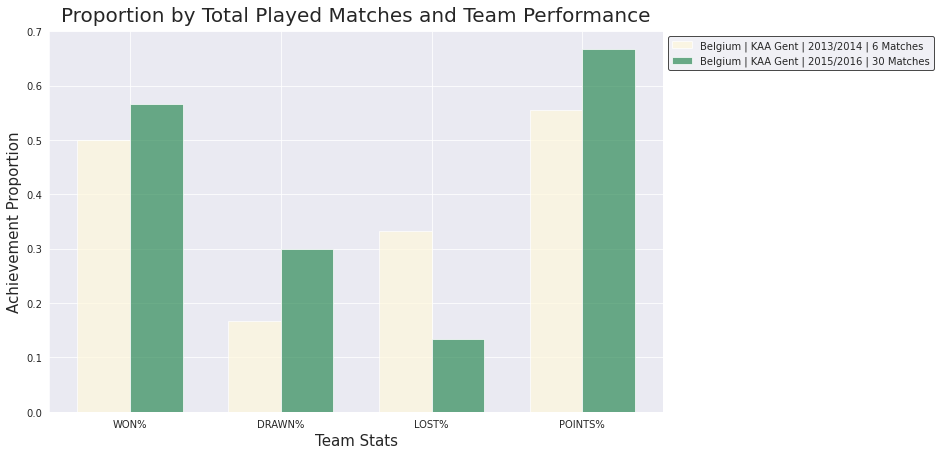

In [46]:
team_performance_plot(1) # Belgium, KAA Gent

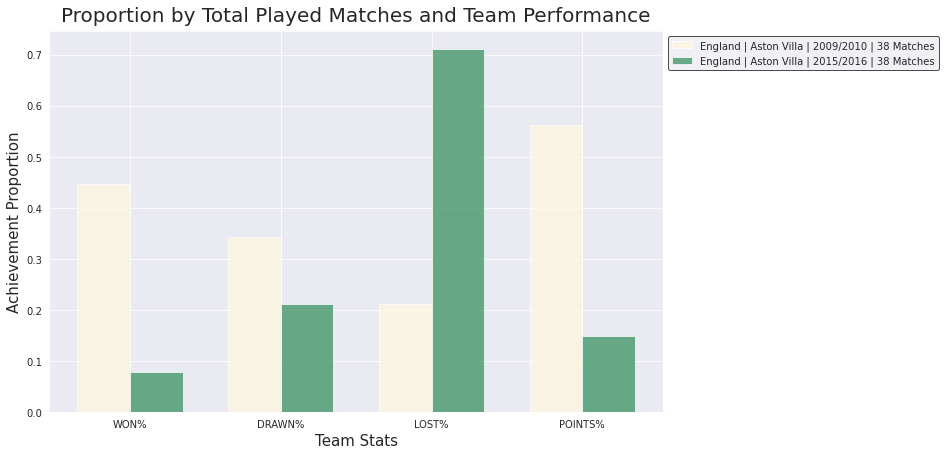

In [47]:
team_performance_plot(2) # England, Aston Villa

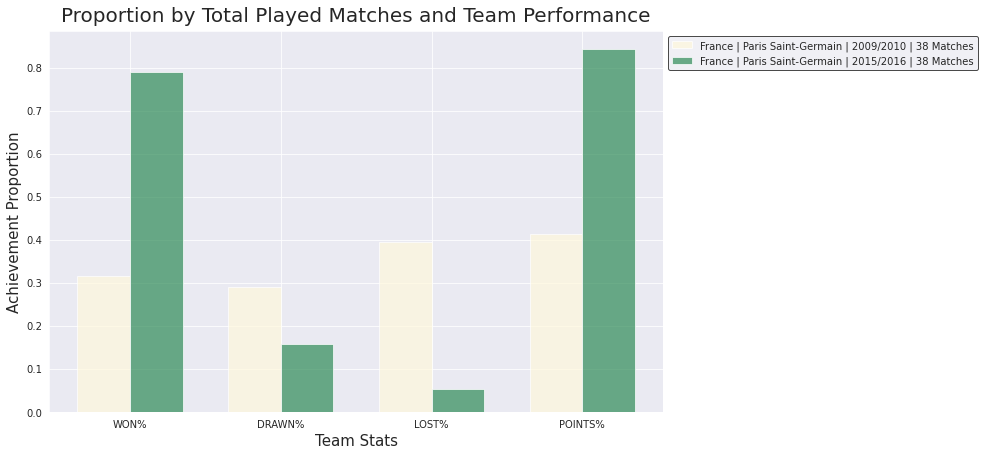

In [48]:
team_performance_plot(3) # France, Paris Saint-Germain

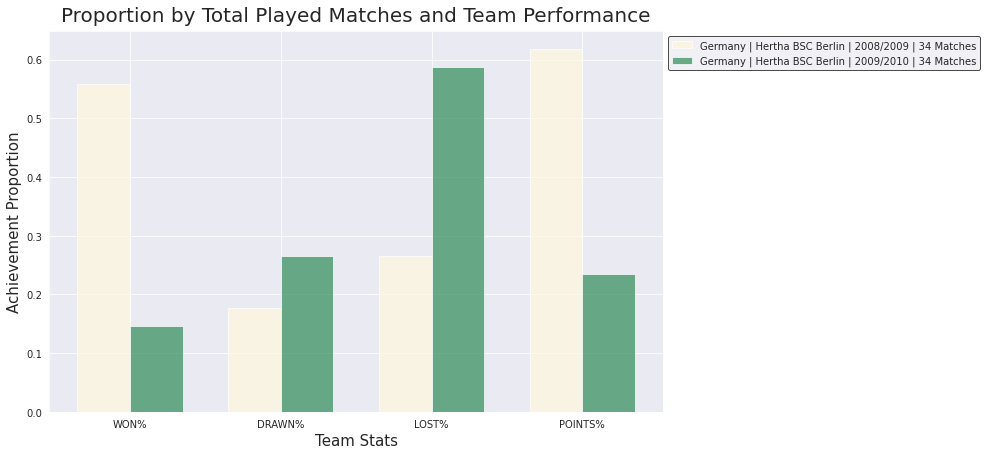

In [49]:
team_performance_plot(4) # Germany, Hertha BSC Berlin

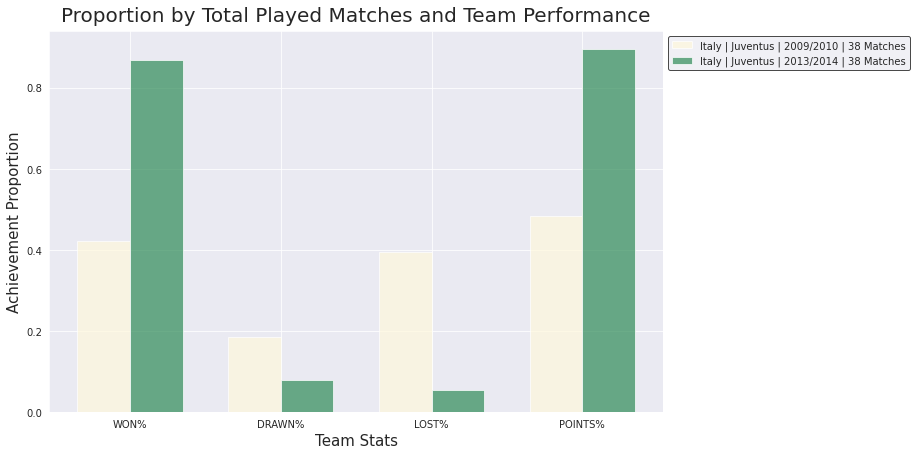

In [50]:
team_performance_plot(5) # Italy, Juventus

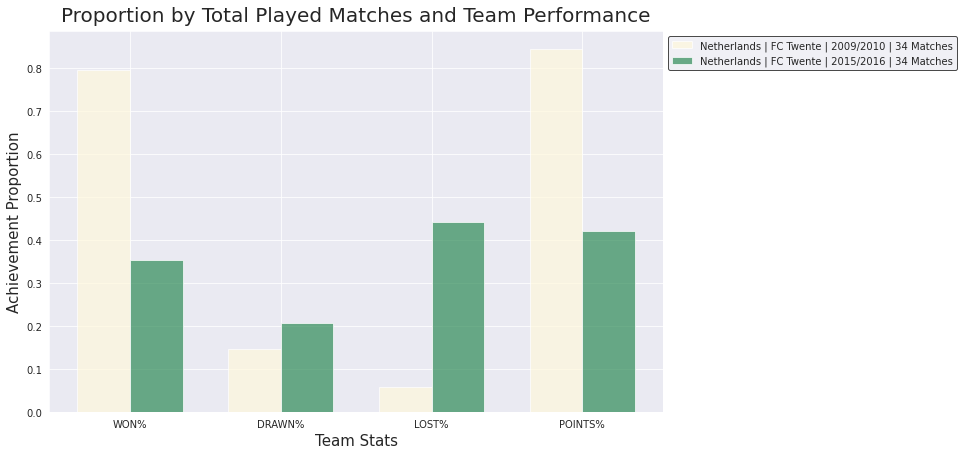

In [51]:
team_performance_plot(6) # Netherlands, FC Twente

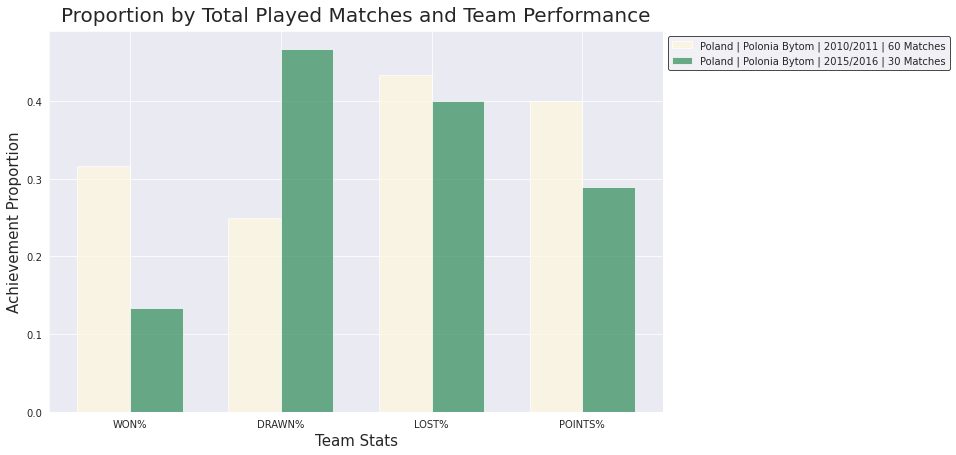

In [52]:
team_performance_plot(7) # Poland, Polonia Bytom

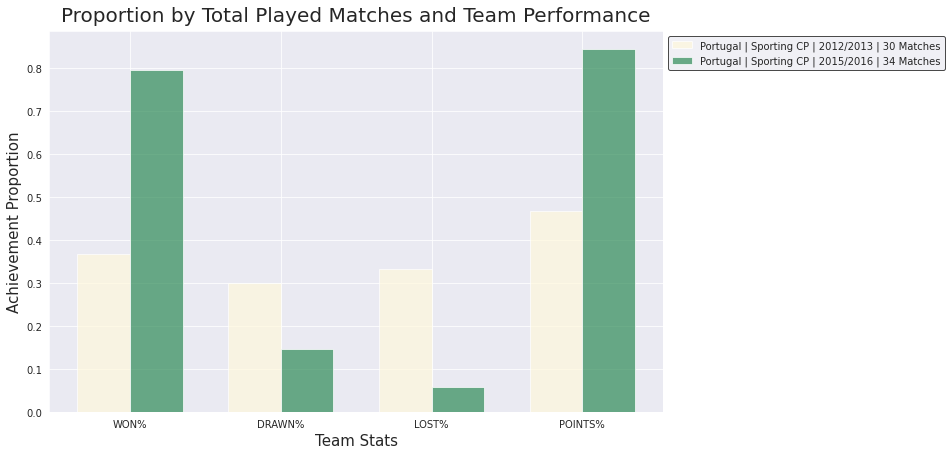

In [53]:
team_performance_plot(8) # Portugal, Sporting CP

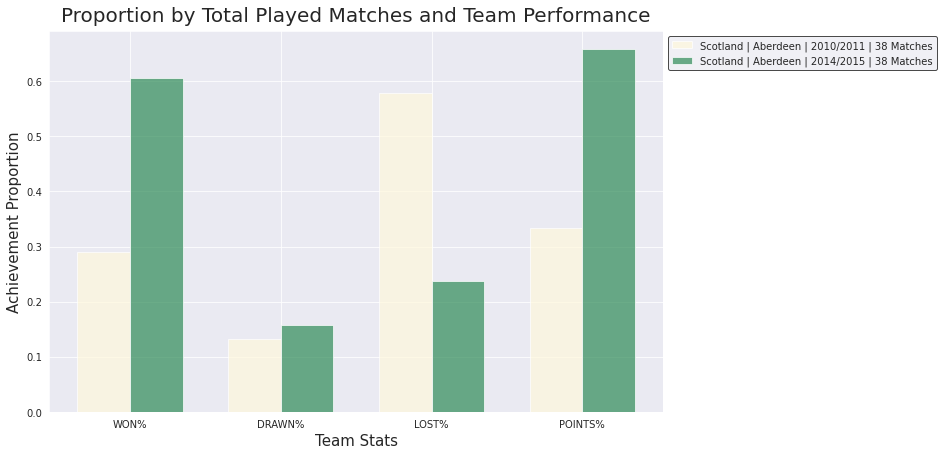

In [54]:
team_performance_plot(9) # Scotland, Aberdeen

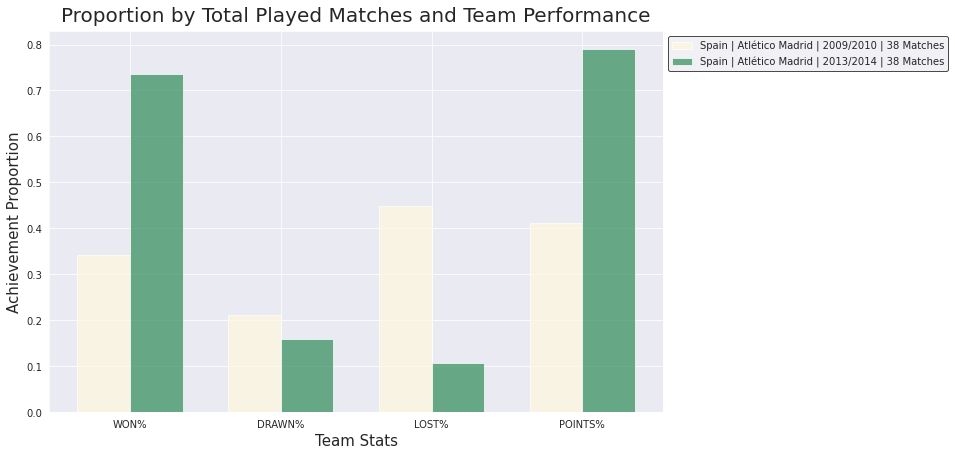

In [55]:
team_performance_plot(10) # Spain, Atlético Madrid

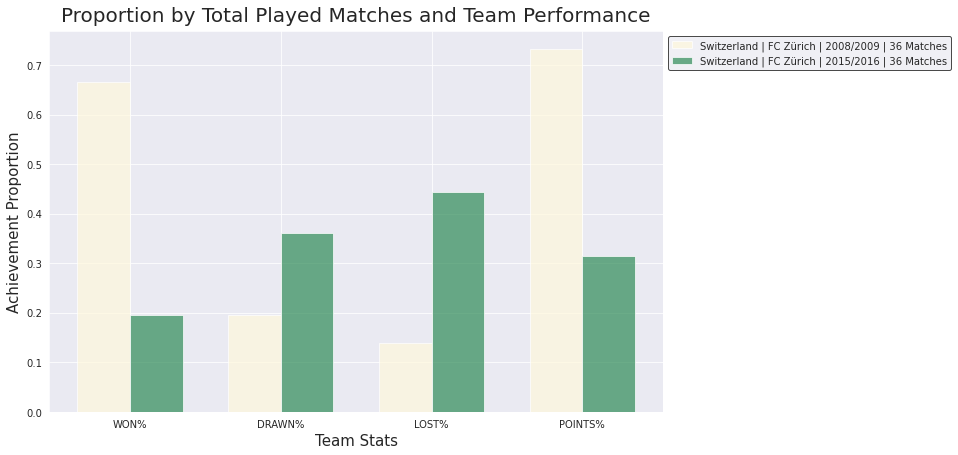

In [56]:
team_performance_plot(11) # Switzerland, FC Zürich

### Research Question 2 : What team attributes lead to the most victories?
<br><br>
**Find the leading team per season per league**

In [57]:
#------------------------------------------------------------------------------------------------------
# Create a dataframe that includes only the leading teams
#------------------------------------------------------------------------------------------------------

# Aggregate Points by MAXIMUM to return a dataframe that includes Max points per season per league
season_max_pts_df = match_df.groupby(['country', 'league', 'season'])['points'].max().reset_index()

# Merge the returned dataframe with the match_df to return a dataframe 
# that contains the related teams and goal difference
pts_top_teams_df = season_max_pts_df.merge(match_df, how='left', on=['country', 'league', 'season', 'points']
                                          )[['country', 'league', 'season', 'team', 'points', 'goal_difference']]

# Re-Aggregate the returned dataframe columns (points) and (goal_difference) by MAXIMUM
pts_goal_diff_top_teams_df = pts_top_teams_df.groupby(['country', 'league', 'season']
                                                     ).max(numeric_only=True).reset_index()

# Merge the returned dataframe with the (match_df) to get back a dataframe 
# that contains the related teams to the Maximum Points and goal difference
season_top_team_df = pts_goal_diff_top_teams_df.merge(pts_top_teams_df, how='inner'
                                                     ).reindex(columns = ['country', 'league', 'season', 
                                                                          'team', 'points', 'goal_difference'])

In [58]:
# Check the returned Dataframe:
season_top_team_df.info()
season_top_team_df.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88 entries, 0 to 87
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   country          88 non-null     object
 1   league           88 non-null     object
 2   season           88 non-null     object
 3   team             88 non-null     object
 4   points           88 non-null     int64 
 5   goal_difference  88 non-null     int64 
dtypes: int64(2), object(4)
memory usage: 4.8+ KB


,country,league,season,team,points,goal_difference
0,Belgium,Belgium Jupiler League,2008/2009,RSC Anderlecht,77,45
1,Belgium,Belgium Jupiler League,2009/2010,RSC Anderlecht,69,42
2,Belgium,Belgium Jupiler League,2010/2011,RSC Anderlecht,65,38
3,Belgium,Belgium Jupiler League,2011/2012,RSC Anderlecht,67,35
4,Belgium,Belgium Jupiler League,2012/2013,RSC Anderlecht,67,42
5,Belgium,Belgium Jupiler League,2013/2014,KV Oostende,14,6
6,Belgium,Belgium Jupiler League,2014/2015,Club Brugge KV,61,41
7,Belgium,Belgium Jupiler League,2015/2016,Club Brugge KV,64,34
8,England,England Premier League,2008/2009,Manchester United,90,44
9,England,England Premier League,2009/2010,Chelsea,86,71


In [59]:
#------------------------------------------------------------------------------------------------------
# Create a dataframe that includes the leading teams and their attributes in their seasons of leading
#------------------------------------------------------------------------------------------------------

# Merge both dataframes (season_top_team_df) and (team_attr_df) on (Team Name) and (Season)
lead_teams_attr_df = season_top_team_df.merge(team_attr_df, how='inner', 
                                              on=['team', 'season'])[team_attr_df.columns]

In [60]:
# Check the returned Dataframe:
lead_teams_attr_df.info()
lead_teams_attr_df.head(15)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67 entries, 0 to 66
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   team                            67 non-null     object
 1   season                          67 non-null     object
 2   buildUpPlaySpeedClass           67 non-null     object
 3   buildUpPlayDribblingClass       67 non-null     object
 4   buildUpPlayPassingClass         67 non-null     object
 5   buildUpPlayPositioningClass     67 non-null     object
 6   chanceCreationPassingClass      67 non-null     object
 7   chanceCreationCrossingClass     67 non-null     object
 8   chanceCreationShootingClass     67 non-null     object
 9   chanceCreationPositioningClass  67 non-null     object
 10  defencePressureClass            67 non-null     object
 11  defenceAggressionClass          67 non-null     object
 12  defenceTeamWidthClass           67 non-null     obje

,team,season,buildUpPlaySpeedClass,buildUpPlayDribblingClass,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassingClass,chanceCreationCrossingClass,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressureClass,defenceAggressionClass,defenceTeamWidthClass,defenceDefenderLineClass
0,RSC Anderlecht,2009/2010,Balanced,Little,Mixed,Organised,Risky,Normal,Normal,Organised,High,Press,Wide,Cover
1,RSC Anderlecht,2010/2011,Balanced,Little,Mixed,Free Form,Risky,Normal,Normal,Organised,High,Press,Wide,Offside Trap
2,RSC Anderlecht,2011/2012,Balanced,Little,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
3,Club Brugge KV,2014/2015,Balanced,Normal,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
4,Club Brugge KV,2015/2016,Balanced,Normal,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
5,Chelsea,2009/2010,Fast,Little,Mixed,Free Form,Normal,Lots,Lots,Free Form,Deep,Press,Normal,Cover
6,Manchester United,2010/2011,Balanced,Little,Mixed,Organised,Normal,Normal,Lots,Free Form,Medium,Press,Normal,Cover
7,Manchester City,2011/2012,Balanced,Little,Mixed,Organised,Normal,Normal,Normal,Free Form,Medium,Press,Normal,Cover
8,Manchester City,2013/2014,Balanced,Little,Mixed,Organised,Normal,Normal,Normal,Free Form,Medium,Press,Normal,Cover
9,Chelsea,2014/2015,Fast,Normal,Mixed,Organised,Normal,Normal,Lots,Organised,Medium,Press,Normal,Cover


In [61]:
# Create a list of the Attributes titles:
attr_title_list = lead_teams_attr_df.columns[2:]


#------------------------------------------------------------------------------------------------------
# Define a Function that reforms the "Team Attributes" titles:
#------------------------------------------------------------------------------------------------------
def title_reformer(team_attr_title):
    """
    A function that reforms the attribute titles to easily readable form!
    i.e: Reform (buildUpPlaySpeedClass) to (Build Up Play Speed Class)
    """            
    #-------------------------------------------------------------------------------------------#
    # I have found the method below at StackOverflow:                                           #
    # link: (https://stackoverflow.com/questions/2277352/split-a-string-at-uppercase-letters) : #
    #       i.e:  >>> import re                                                                 #
    #             >>> re.findall('[A-Z][^A-Z]*', 'TheLongAndWindingRoad')                       #
    #             >>> [returns] -->  [The,Long,And,Winding,Road]                                #
    #-------------------------------------------------------------------------------------------#                                                                                           #
    

    
    # First, Capitalize the first letter of the column's name without changing the rest,        
    # then, split the string at the uppercase letters, and store the returned strings in a list    
    title_word_list = []
    title_word_list = re.findall('[A-Z][^A-Z]*', team_attr_title[0].title() + team_attr_title[1:])
        
    
    # Return the concatenation of the strings that are inside the list
    return " ".join(title_word_list).title()


#------------------------------------------------------------------------------------------------------
# Plot Function Set-Up
#------------------------------------------------------------------------------------------------------
def team_attr_plot(index):
    """Plot leading teams attribute"""
    
    # Get the column name that corresponds to the index number, which had been passed to the function
    team_attr_title = attr_title_list[index-1] 
    
    
    # Aggregate the column by value_counts(), then plot the corresponding Pie Chart.
    lead_teams_attr_df[team_attr_title].value_counts().plot.pie(figsize=(10,10), 
                                                                ylabel="", textprops={"fontsize":20})
    plt.title(title_reformer(team_attr_title), fontdict = {'fontsize' : 25})
    plt.legend(loc='best', fancybox=True, framealpha=0.6, edgecolor="black");

<br><br>**The most common attributes of leading teams**

In [62]:
#------------------------------------------------------------------------------------------------------
# Create a DataFrame containing the Most Common Attributes of the Leading Teams over the period
#------------------------------------------------------------------------------------------------------

# Create a DataFrame containing the Attributes titles and the most common value per each.
# Using list comprehension to make a list of tuples: [(Attribute title, most common value), ...],
# then converting it to DataFrame by passing it to the function: pd.DataFrame( <list_of_tuples> )
common_attr_df = pd.DataFrame([tuple([title_reformer(attr_title_list[i]), 
                                      lead_teams_attr_df[attr_title_list[i]].mode()[0]]
                                    ) for i in range(len(attr_title_list))], columns=['attribute', 
                                                                                      'most_common_value'])
common_attr_df.index += 1 # Shift the DataFrame index by 1


# The most common value per Attribute.
common_attr_df

,attribute,most_common_value
1,Build Up Play Speed Class,Balanced
2,Build Up Play Dribbling Class,Little
3,Build Up Play Passing Class,Mixed
4,Build Up Play Positioning Class,Organised
5,Chance Creation Passing Class,Normal
6,Chance Creation Crossing Class,Normal
7,Chance Creation Shooting Class,Normal
8,Chance Creation Positioning Class,Organised
9,Defence Pressure Class,Medium
10,Defence Aggression Class,Press


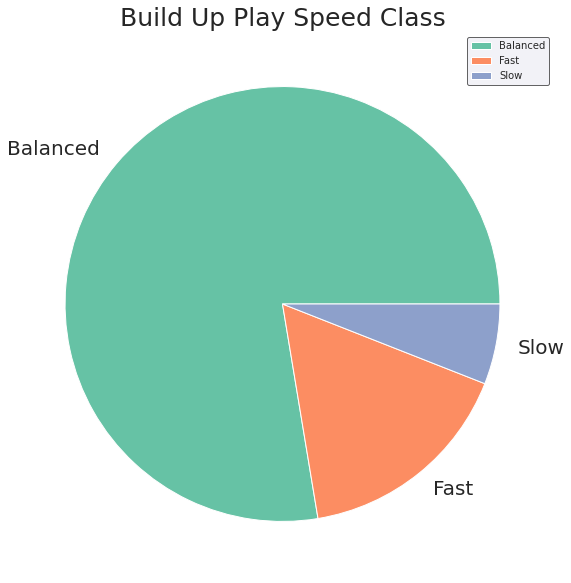

In [63]:
team_attr_plot(1)

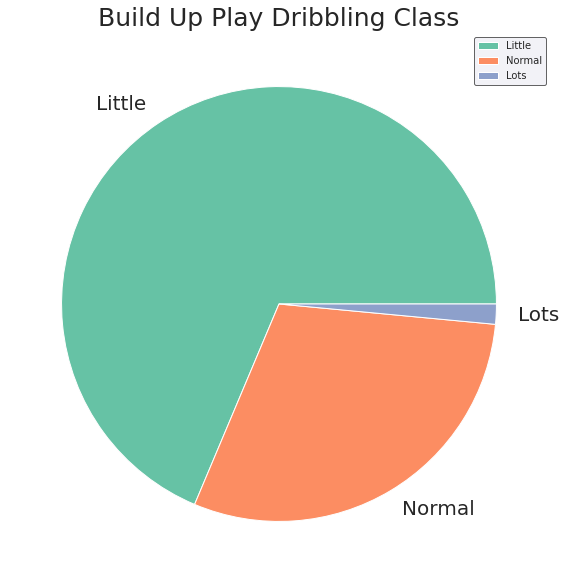

In [64]:
team_attr_plot(2)

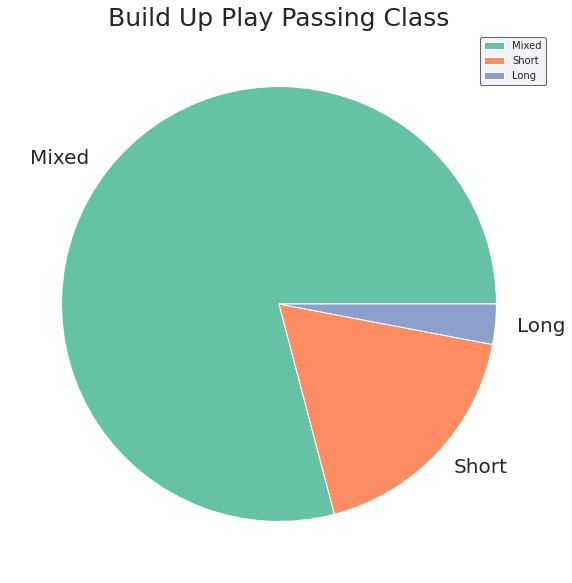

In [65]:
team_attr_plot(3)

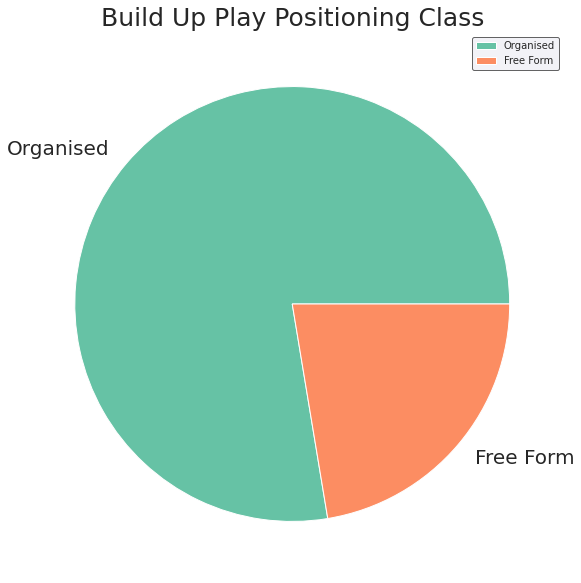

In [66]:
team_attr_plot(4)

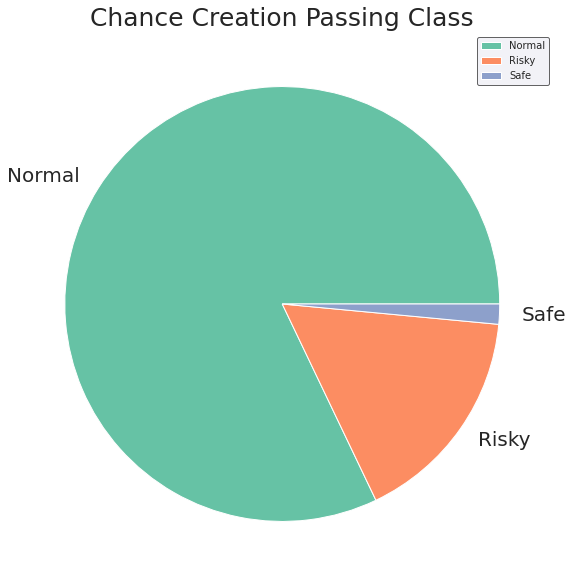

In [67]:
team_attr_plot(5)

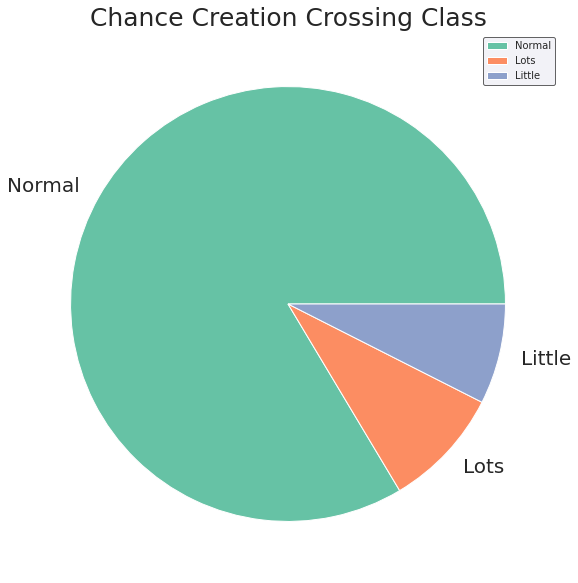

In [68]:
team_attr_plot(6)

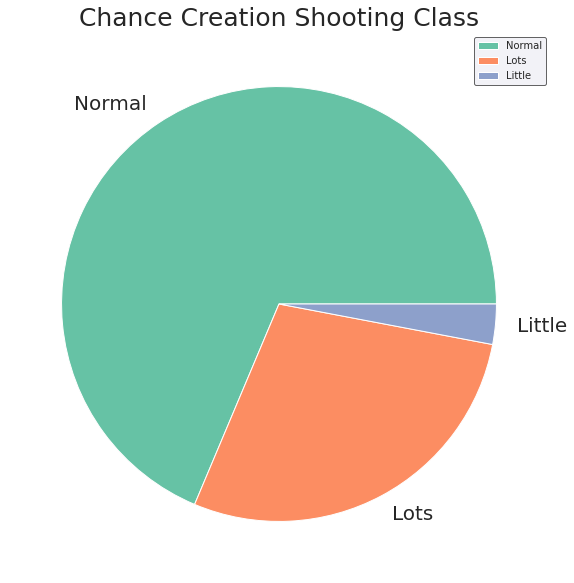

In [69]:
team_attr_plot(7)

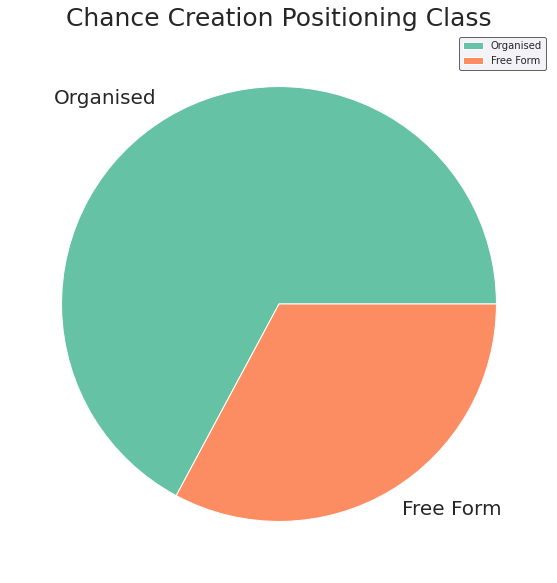

In [70]:
team_attr_plot(8)

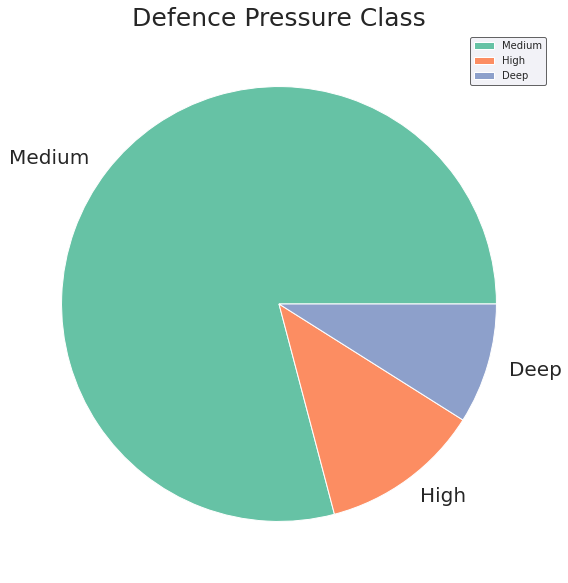

In [71]:
team_attr_plot(9)

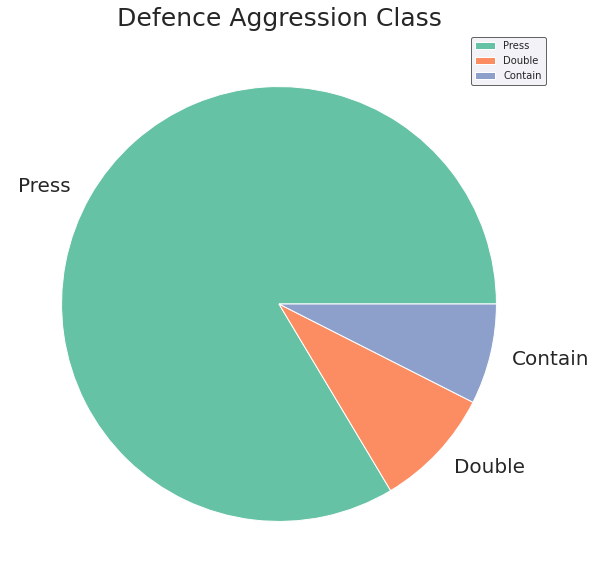

In [72]:
team_attr_plot(10)

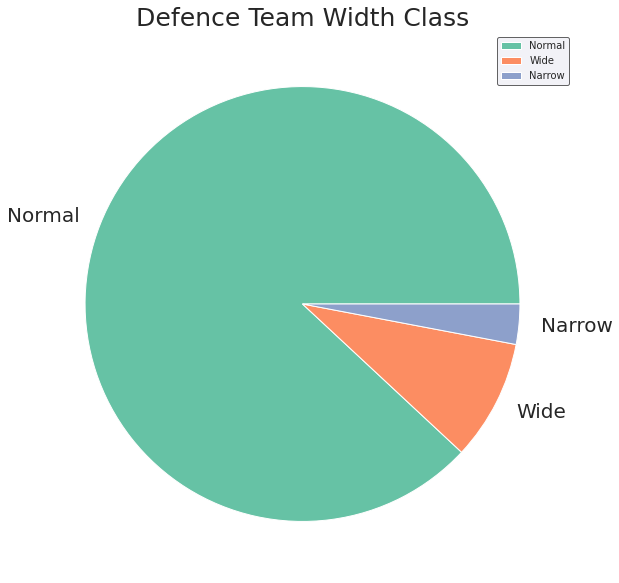

In [73]:
team_attr_plot(11)

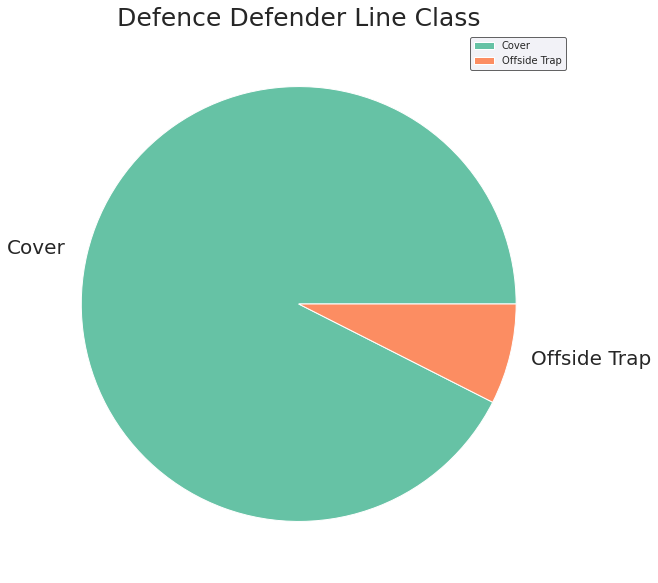

In [74]:
team_attr_plot(12)

### Research Question 3 : Which players had the most penalties?

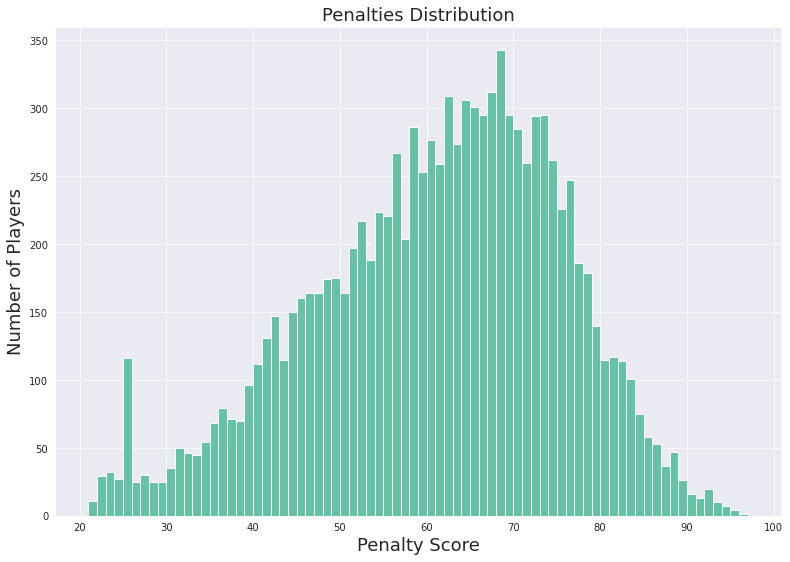

In [75]:
# Penalties frequency distribution using Histogram
max_penalties_df.hist('penalties', bins=range(21, 98), figsize=(13,9))
plt.xlabel('Penalty Score', fontsize=18)
plt.ylabel('Number of Players', fontsize=18)
plt.title('Penalties Distribution', fontsize=18);

In [76]:
# Return the number of players per penalty score, sorted by penalty score
max_penalties_df.penalties.value_counts()#.sort_values()

68    343
67    312
62    309
64    306
65    301
     ... 
21     11
93     10
94      7
95      4
96      1
Name: penalties, Length: 76, dtype: int64

In [77]:
# Return the number of players per penalty score for the first highest Five scores
max_penalties_df.penalties.value_counts().sort_index(ascending=False)[:5]#.sum()

96     1
95     4
94     7
93    10
92    20
Name: penalties, dtype: int64

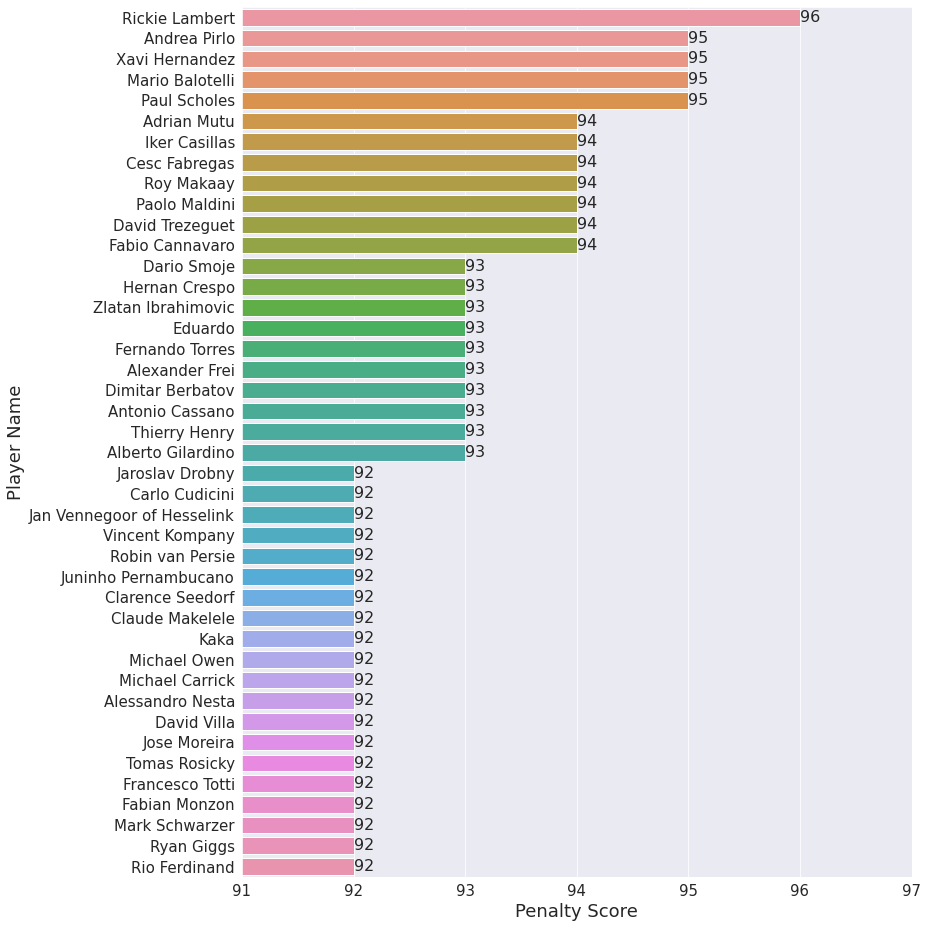

In [78]:
# Plot the players per the Highest Five Penalty Scores
chart = sns.barplot(y='player_name', x='penalties', data=max_penalties_df.iloc[:42, :2])
chart.bar_label(chart.containers[0], fontsize=16)
plt.gcf().set_size_inches(12, 16)
plt.xlim(91, 97)
plt.ylabel('Player Name', fontsize=18)
plt.xlabel('Penalty Score', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

In [79]:
# Return the player's data who scored the maximum penalty score
max_penalties_df.loc[max_penalties_df['penalties'].idxmax()]

player_name    Rickie Lambert
penalties                  96
date               2016-03-10
Name: 0, dtype: object

<h2 id="conclusions">Conclusions</h2>


>It is noticeable that some teams have ***improved*** their performance radically through two seasons like ***KAA Gent***, three seasons like ***Sporting CP***, four seasons like ***Aberdeen, Juventus, and Atlético Madrid***, and six seasons like ***Paris Saint-Germain***.

>Furthermore, some other teams whose performance ***descends*** radically through one season like ***Hertha BSC Berlin***, five seasons like ***Polonia Bytom***, six seasons like ***FC Twente and Aston Villa***, and seven seasons like ***FC Zürich***.

>Also, It is ***noticeable*** that there are ***highly dominant attributes*** of the leading teams:

|Team Attribute |Most Common Value|
|:-----|:-----:|
|Build Up Play Speed Class|Balanced|
|Build Up Play Dribbling Class|Little|
|Build Up Play Passing Class|Mixed|
|Build Up Play Positioning Class|Organised|
|Chance Creation Passing Class|Normal|
|Chance Creation Crossing Class|Normal|
|Chance Creation Shooting Class|Normal|
|Chance Creation Positioning Class|Organised|
|Defence Pressure Class|Medium|
|Defence Aggression Class|Press|
|Defence Team Width Class|Normal|
|Defence Defender Line Class|Cover|

>Finally, by looking at the data, we can notice that there's a ***single player*** with the ***highest*** penalty score, who is:<br><mark><b><i>Rickie Lambert : 96 penalties</i></b></mark>. While The ***most common*** penalty score is ***68 penalties***.<br>We can also notice that, the distribution of the penalty scores is a lookalike normal distribution.
>><mark><b>Suggestions for further research:</b></mark><br>
<i>Is the distribution of the penalty scores within the same league and the same season a lookalike normal distribution?
Or does that differ among different leagues due to the divergent characteristics of the players among the various countries?</i>


<br><br>
### Limitations

* **Issues with the dataset**
>* We're working with sample data, which implies uncertainty (a different sample may lead to different results!).
>* The exploratory phase of the most common attributes of the leading teams had based on the categorical values of teams' attributes instead of the numerical ones due to a large number of nulls, and that for sure will affect the accuracy of the analysis!

* **Issues with the methods of analysis**
>* There is no statistical inference performed in our analysis (to test the significance of the results that we found!)